# PaMoDaCo: CMIP6 vs LMR

---

## Overview
<font color=green> This notebook compares the output of physics-based models of the climate of the past millennium to reconstructions from the Last Millennium Reanalysis project and allows a quick glance at the simulated and reconstructed climate response to major volcanic events of the Common Era. In the process, it illustrates how to: </font>

1. Pull and process CMIP6 output from AWS
1. Plot an envelope of LMR simulations with CMIP6 output
1. Plot spatial variation of LMR and CMIP6 snapshots

- **Time to learn**: 25 minutes

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |
| [Accessing CMIP6 output from the cloud](data_from_esm_cloudcat.ipynb) | Helpful | Background about the structure of the data catalog |



---

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from collections import defaultdict

import pandas as pd
import numpy as np

import xarray as xr
import cftime

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec

import pyleoclim as pyleo

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil

import intake

## Data-model comparison of global-mean surface temperature

### Last Millennium Reanalysis Project (LMR) 

Many methods have been proposed to reconstruct past climates. An increasingly mature and popular framework is that of [paleoclimate data assimilation](https://pastglobalchanges.org/publications/pages-magazines/pages-magazine/7318), which has been applied to many time intervals. In particular, the [Last Millennium Reanalysis](https://cpo.noaa.gov/News/News-Article/ArtMID/6226/ArticleID/1807/Last-Millennium-Reanalysis-now-at-NOAAs-National-Centers-for-Environmental-Information-marking-major-milestone) provides estimates of gridded climate fields like surface air temperature, sea-level pressure, precipitation, and others, together with estimates of their uncertainties (which are often at least as important as the central estimates). (Hakim et al, 2016 and Tardif et al, 2019)

In a nutshell, LMR blends information from paleoclimate proxies and climate models, with models providing estimates of relationships over space and between variables, while proxies give the timing and amplitude of events. To explore the full distribution of possible trajectories, LMR uses an [ensemble Kalman filter](https://en.wikipedia.org/wiki/Ensemble_Kalman_filter), which employs a Monte Carlo approach to this exploration: each reconstruction starts with a sample of 100 randomly-drawn climate snapshots from a model simulation (each such snapshot is called a _member_). Proxy measurements for each year are used to establish the likelihood of each climate snapshot. In addition, the algorithm conducts 20-50 "iterations", where it selects 75% of the catalog of proxies and reserves the other 25% for validation.
By doing this many times (50 iterations each with different 100 snapshots) we can build a 5000-strong picture of how the climate of the Common Era may have unfolded, capturing uncertainties about this history.


We'll load datasets using **[Xarray](https://xarray.dev/)**. Xarray is specifically designed to accommodate multidimensional data, like that from a NetCDF file. Let's load 1000 traces of GMST reconstructed using LMR included in Neukom et al. (2019).  

In [2]:
file_path = Path(os.getcwd()).parent.parent/'data/p2k_ngeo19_recons.nc'
p2k_nc = xr.open_dataset(file_path)
p2k_nc

<xarray.Dataset>
Dimensions:  (year: 2000, ens: 1000)
Coordinates:
  * year     (year) int64 1 2 3 4 5 6 7 8 ... 1994 1995 1996 1997 1998 1999 2000
  * ens      (ens) int64 1 2 3 4 5 6 7 8 9 ... 993 994 995 996 997 998 999 1000
Data variables:
    LMRv2.1  (year, ens) float32 ...
    BHM      (year, ens) float64 ...
    DA       (year, ens) float64 ...
    CPS_new  (year, ens) float64 ...
    CPS      (year, ens) float64 ...
    OIE      (year, ens) float64 ...
    PAI      (year, ens) float64 ...
    PCR      (year, ens) float64 ...
    M08      (year, ens) float64 ...

In [3]:
%%time
variable_name = 'LMRv2.1'
ens_grps = p2k_nc.groupby('ens')
traces = []

for im in range(len(p2k_nc.ens)):
    ens_run = ens_grps[im+1].data_vars[variable_name]
    traces.append(pyleo.Series(time=p2k_nc.year, value=ens_run,
                      time_name='Time', time_unit='year',
                      value_name='GMST', value_unit='$^{\circ}$C'))

lmr_ens = pyleo.EnsembleSeries(traces)

CPU times: user 2.25 s, sys: 64.9 ms, total: 2.31 s
Wall time: 2.55 s


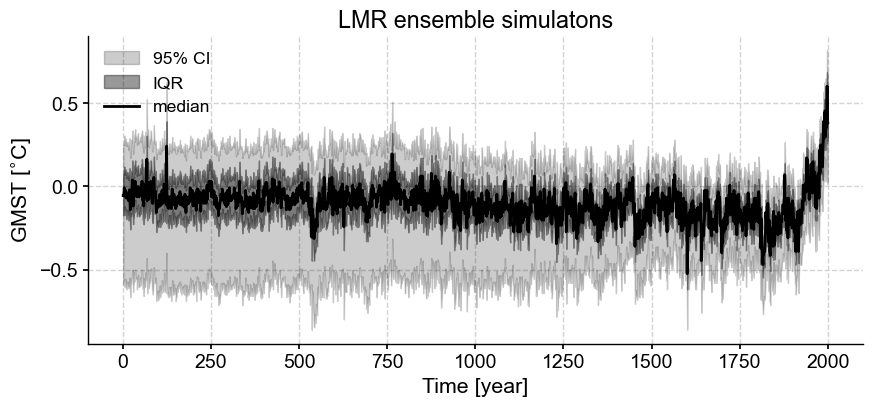

In [72]:
lmr_ens.plot_envelope(title='LMR ensemble', shade_clr='k', curve_clr='k'); 

### CMIP6

[Need some discussion of CMIP6]

<font color=green> suggest discussing [PMIP4 past1000](https://pmip4.lsce.ipsl.fr/doku.php/exp_design:lm) instead, and saying that it's just a tiny sliver of CMIP6, for which there is, thankfully, some cloud infrastructure that we can use.  Explain why there are only 3 simulations available at the moment, and how many are supposed to be there eventually. </font>

#### Pulling Data

CMIP6 output constitutes such a large volume of data that no single place hosts the whole collection. A selection of PMIP4 simulations covering the interval 850 to 1850 are available via Pangeo-Forge, while the much larger swath is hosted by AWS as part of the [AWS Open Data Sponsorship Program](https://aws.amazon.com/opendata/public-datasets/) and Google in [Google Cloud Public Datasets](https://cloud.google.com/public-datasets). In order to look at the interval 850 to present (ish), we'll need both. 

PMIP output for `tas` available via cloud pointer:
- `MIROC-ES2L.past1000.r1i1p1f2.Amon.tas` (Pangeo-Forge)
- `MRI-ESM2-0.past1000.r1i1p1f1.Amon.tas` (Pangeo-Forge, AWS)
- `MPI-ESM1-2-LR.past2k.r1i1p1f1.Amon.tas` (Pangeo-Forge)

CMIP output is available for all three via AWS, so let's tap Pangeo-Forge for PMIP, and AWS for CMIP. 

##### AWS 
To get data from AWS, we will use `intake` to load a json file with information about the AWS holdings, query it, and then pull the output of interest. 

In [5]:
# for AWS S3:
col = intake.open_esm_datastore("https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json")

In [6]:
experiments = ['historical', 'past1000']
sources = ['MIROC-ES2L', 'MRI-ESM2-0', 'MPI-ESM1-2-LR']
variables = ['tas']
members = ['r1i1p1f1', 'r1i1p1f2']

In [7]:
query_d = dict(source_id=sources, 
     experiment_id=experiments, 
     grid_label='gn', 
     variable_id=variables, 
     member_id = members,
     table_id='Amon'
    )

In [8]:
search_res = col.search(**query_d)

In [9]:
_esm_data_d = search_res.to_dataset_dict(require_all_on=['source_id', 'grid_label', 'table_id', 'variant_label'],#['source_id', 'experiment_id'], 
                                      xarray_open_kwargs={'consolidated': True,'use_cftime':True, 'chunks':{}},
                                   storage_options={'token': 'anon'})
_esm_data_d.keys()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


dict_keys(['CMIP.MRI.MRI-ESM2-0.historical.Amon.gn', 'CMIP.MIROC.MIROC-ES2L.historical.Amon.gn', 'PMIP.MRI.MRI-ESM2-0.past1000.Amon.gn', 'CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amon.gn'])

In [10]:
esm_data_d = {}
for key in _esm_data_d.keys():
    parts = key.split('.', 4)
    if parts[1] not in esm_data_d.keys():
        esm_data_d[parts[1]]= defaultdict(dict)
    esm_data_d[parts[1]][parts[2]][parts[3]] = _esm_data_d[key]

##### Pangeo-Forge

In [11]:
PF_cloud_pointers = {'MIROC': 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/CMIP6-PMIP-feedstock/CMIP6.PMIP.MIROC.MIROC-ES2L.past1000.r1i1p1f2.Amon.tas.gn.v20200318.zarr', 
                     'MRI': 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/CMIP6-PMIP-feedstock/CMIP6.PMIP.MRI.MRI-ESM2-0.past1000.r1i1p1f1.Amon.tas.gn.v20200120.zarr', 
                     'MPI': 'https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/pangeo-forge/CMIP6-PMIP-feedstock/CMIP6.PMIP.MPI-M.MPI-ESM1-2-LR.past2k.r1i1p1f1.Amon.tas.gn.v20210714.zarr'}

In [12]:
PF_data_d = {key: xr.open_dataset(PF_cloud_pointers[key], engine='zarr', chunks={}, use_cftime=True) for key in PF_cloud_pointers.keys()}


#### Processing data
Data in hand, we need to check that it follows the structure we are expecting, and tune that structure where appropriate. Once we know the data are orderly, we will calculate the global mean annual surface air temperature anomaly relative to the interval 1900-1980, per the approach used for the LMR 2.1 data loaded above. 

In [13]:

def calc_climatology(ds):
    interval = ds.sel(time=(ds.time.dt.year < 1980) | (ds.time.dt.year >= 1900))
    climatology = interval.groupby("time.month").mean("time")
    return climatology

def remove_seasonality(ds, climatology):
    anomalies = ds.groupby("time.month") - climatology
    return anomalies

def global_mean(ds, lat_weighted=False):
    if lat_weighted is True:
        lat_weights = np.cos(np.deg2rad(ds.lat))
        lat_weights.name = "lat_weights"

        ds_lat_weighted = ds.weighted(lat_weights)
        ds_global_mean = ds_lat_weighted.mean(("lon", "lat"))
    else:
        ds_global_mean = ds.mean(("lon", "lat"))
    return ds_global_mean

def annualize(ds):
    ds_annualized = ds.groupby('time.year').mean('time')
    return ds_annualized


In [15]:
def calc_da_ps(da):
    ps = pyleo.Series(da.year, da.squeeze(), time_unit='year', 
                                clean_ts=False, value_name='Temp anomaly ($^{\circ}$C)')#atm temp @2m')
    return {'da': da.squeeze(), 'ps':ps}
    

In [16]:
annualized_anomaly_gwm = {}
annualized_anomaly_spatial = {}

<font color=green> You need to explain what's happening below. Something like: "Groups participating in PMIP do their best to standardize their output, but some idiosyncrasies remain.  We need to iron out them out before we can perform our analysis". </font>

##### MIROC

In [17]:
miroc_model = 'MIROC-ES2L'

In [18]:
_miroc_past1000 = PF_data_d['MIROC']
_miroc_past1000.dims

Frozen({'lat': 64, 'bnds': 2, 'lon': 128, 'time': 12011})

The `time: 12011` is a bit suspicious. Checking for a hiccough never hurts. 

In [19]:
xr.CFTimeIndex(_miroc_past1000.time.data, name=None).is_monotonic_increasing

False

Ah. Finding these wrinkles can tricky. A simple strategy is to group the data by year and check to see if any years have more than 12 entries. 

In [20]:
# group by year
miroc_yeargrps = _miroc_past1000.groupby('time.year').groups

# years with more than 12 entries
miroc_years = [key for key in miroc_yeargrps.keys() if len(miroc_yeargrps[key])>12]
miroc_years

[850]

In [21]:
_miroc_past1000.time[:13].data

array([cftime.Datetime360Day(850, 1, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 2, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 3, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 4, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 5, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 6, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 7, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 8, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 9, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 10, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 1, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.Datetime360Day(850, 2, 15, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)

In [22]:
_miroc_past1000.time.encoding

{'chunks': (12011,),
 'preferred_chunks': {'time': 12011},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 'units': 'days since 0850-01-16 00:00:00.000000',
 'calendar': '360_day',
 'dtype': dtype('int64')}

Now we can slice off the initial 11 months and convert the calendar to 'proleptic_gregorian'. 

In [23]:
miroc_past1000 = _miroc_past1000.isel({'time':slice(11,len(_miroc_past1000.time))})#time[:74]
miroc_past1000 = miroc_past1000.convert_calendar('proleptic_gregorian', use_cftime=True, align_on='date')

Now let's convert the calendar of the `historical` output

In [24]:
miroc_hist = esm_data_d['MIROC']['MIROC-ES2L']['historical'].convert_calendar('proleptic_gregorian', use_cftime=True).squeeze()                      

In [25]:
miroc_exp = {'past1000': miroc_past1000['tas'], 'historical': miroc_hist['tas']}

In [26]:
miroc_climatology = calc_climatology(miroc_hist['tas'])

In [27]:
miroc_annualized_anomaly_spatial = {key: annualize(remove_seasonality(miroc_exp[key], miroc_climatology)) for key in miroc_exp.keys()}
annualized_anomaly_spatial['MIROC']=miroc_annualized_anomaly_spatial

/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 1000 times more chunks
  return self.array[key]
/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]


In [28]:
%%time
miroc_yr_gmt_anom = {key: calc_da_ps(annualize(global_mean(remove_seasonality(miroc_exp[key], miroc_climatology), lat_weighted=True).compute())) for key in miroc_exp.keys()}
for key in miroc_yr_gmt_anom.keys():
    miroc_yr_gmt_anom[key]['ps'].label = '_'.join([miroc_model, key])
    
annualized_anomaly_gwm['MIROC'] = miroc_yr_gmt_anom

/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 1000 times more chunks
  return self.array[key]
/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]


CPU times: user 1min 34s, sys: 15.1 s, total: 1min 49s
Wall time: 4min 50s


##### MRI

In [29]:
mri_model = 'MRI-ESM2-0'

In [30]:
mri_past1000 = PF_data_d['MRI']
mri_past1000.time.encoding

{'chunks': (12000,),
 'preferred_chunks': {'time': 12000},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 'units': 'hours since 0850-01-16 12:00:00.000000',
 'calendar': 'proleptic_gregorian',
 'dtype': dtype('int64')}

In [31]:
mri_hist = esm_data_d['MRI']['MRI-ESM2-0']['historical']
mri_hist.time.encoding

{'chunks': (1980,),
 'preferred_chunks': {'time': 1980},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 '_FillValue': nan,
 'units': 'days since 1850-01-01',
 'calendar': 'proleptic_gregorian',
 'dtype': dtype('float64')}

In [32]:
mri_climatology = calc_climatology(mri_hist['tas'])

In [33]:
mri_exp = {'past1000': mri_past1000['tas'], 'historical': mri_hist['tas']}

In [34]:
%%time
mri_annualized_anomaly_spatial = {key: annualize(remove_seasonality(mri_exp[key], mri_climatology)) for key in mri_exp.keys()}
annualized_anomaly_spatial['MRI']=mri_annualized_anomaly_spatial

/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 1000 times more chunks
  return self.array[key]
/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]


CPU times: user 5.65 s, sys: 126 ms, total: 5.77 s
Wall time: 6.06 s


In [35]:
%%time
mri_yr_gmt_anom = {key: calc_da_ps(annualize(global_mean(remove_seasonality(mri_exp[key], mri_climatology), lat_weighted=True).compute())) for key in mri_exp.keys()}
for key in mri_yr_gmt_anom.keys():
    mri_yr_gmt_anom[key]['ps'].label = '_'.join([mri_model, key])
    
annualized_anomaly_gwm['MRI'] = mri_yr_gmt_anom

/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 1000 times more chunks
  return self.array[key]
/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]


CPU times: user 1min 6s, sys: 21.7 s, total: 1min 27s
Wall time: 1min 39s


##### MPI

In [36]:
mpi_model = 'MPI-ESM1-2-LR'

In [37]:
mpi_past2k = PF_data_d['MPI']
mpi_past2k.time.encoding

{'chunks': (22200,),
 'preferred_chunks': {'time': 22200},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 'units': 'hours since 7001-01-16 12:00:00.000000',
 'calendar': 'proleptic_gregorian',
 'dtype': dtype('int64')}

Wow... `'hours since 7001-01-16 12:00:00.000000'`


If we shift time back 7001 years, the start year becomes 0 and the end year is 1850, consistent with the fact that the MPI-M output is for the past2k, not past1000.

In [38]:
mpi_past2k = mpi_past2k.assign_coords(time=xr.CFTimeIndex(mpi_past2k['time'].values).shift(-7001*12, 'M'))
mpi_past1000 = mpi_past2k.sel(time=(mpi_past2k.time.dt.year >= 850))

In [39]:
mpi_hist = esm_data_d['MPI-M'][mpi_model]['historical']
mpi_hist.time.encoding

{'chunks': (1980,),
 'preferred_chunks': {'time': 1980},
 'compressor': Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0),
 'filters': None,
 'units': 'hours since 1850-01-16 12:00:00.000000',
 'calendar': 'proleptic_gregorian',
 'dtype': dtype('int64')}

In [40]:
mpi_climatology = calc_climatology(mpi_hist['tas'])

In [41]:
mpi_exp = {'past1000': mpi_past1000['tas'], 'historical': mpi_hist['tas']}

In [42]:
%%time
mpi_yr_gmt_anom = {key: calc_da_ps(annualize(global_mean(remove_seasonality(mpi_exp[key], mpi_climatology), lat_weighted=True).compute())) for key in mpi_exp.keys()}
for key in mpi_yr_gmt_anom.keys():
    mpi_yr_gmt_anom[key]['ps'].label = '_'.join([mpi_model, key])
    
annualized_anomaly_gwm['MPI'] = mpi_yr_gmt_anom

/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 1000 times more chunks
  return self.array[key]
/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]


CPU times: user 43.4 s, sys: 9.63 s, total: 53 s
Wall time: 54.3 s


In [43]:
%%time
mpi_annualized_anomaly_spatial = {key: annualize(remove_seasonality(mpi_exp[key], mpi_climatology)) for key in mpi_exp.keys()}
annualized_anomaly_spatial['MPI']=mpi_annualized_anomaly_spatial

/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 1000 times more chunks
  return self.array[key]
/Users/jlanders/opt/miniconda3/envs/sandbox310/lib/python3.10/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 165 times more chunks
  return self.array[key]


CPU times: user 5.97 s, sys: 145 ms, total: 6.11 s
Wall time: 6.61 s


### Comparing simulations to reconstructions

<font color=green> We now have all the pieces in hand to compare reconstructions to simulations. The goal of this operation is to ... </font>

(850.0, 2014.0)

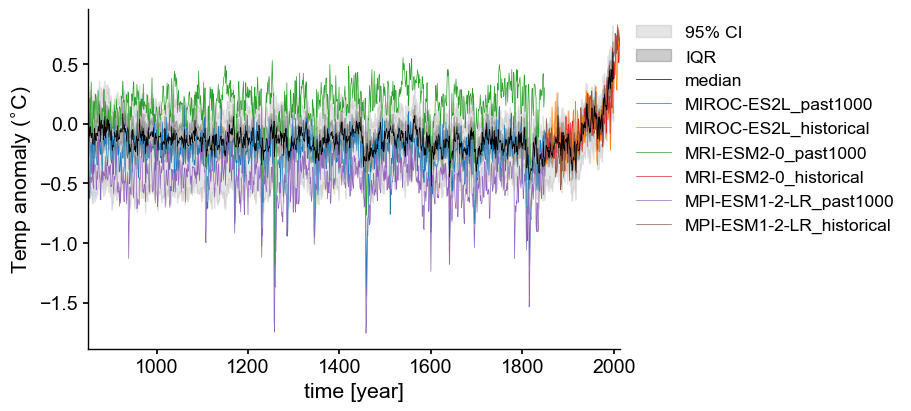

In [46]:
# Create a figure with a gridspec layout to allow us to have two differently sized subplots with a shared x-axis.
fig = plt.figure(figsize=(9, 4), layout="constrained")
spec = fig.add_gridspec(4, 1, hspace=.20)#, sharex=True)

# ax1 = fig.add_subplot(spec[4:, :])
ax2 = fig.add_subplot(spec[:4, :])

# Same EnsembleSeries envelope from above, this time with lines that correspond to volcanic events
lmr_ens.plot_envelope( shade_alpha = .1,  ylabel='GMST [$^{\circ}$C]', 
                                                   curve_lw=.5, shade_clr='k', curve_clr='k', ax=ax2)
for key in annualized_anomaly_gwm.keys():
    for exp in annualized_anomaly_gwm[key].keys():
        annualized_anomaly_gwm[key][exp]['ps'].plot(ax=ax2, linewidth=.5)
    
ax2.xaxis.set_ticks_position('bottom')
# ax2.set_xticklabels([])
# ax2.set_xlabel('')
ax2.grid(False)
ax2.legend(bbox_to_anchor = (1,1))

xlims = [850, 2014]#lmr_ds_ungridded.time.dt.year.min(), lmr_ds_ungridded.time.dt.year.max()]
# ax1.set_xlim(xlims)
ax2.set_xlim(xlims)

<font color=green> Commentary please!! You can't possibly leave this as is without some remarks about the amplitude of pertubations, offsets, etc. </font>

## Spatial Visualization

<font color=green> Scientifically, why do people want to look at things over space? Let's start with that instead of diving head-first into technicalities. You're not even explaining that you are picking the year 1816 or why... That's kind of relevant, wouldn't you think? </font>


Loading large data files (e.g., compilations, model output), even if only to pull a subset, can be somewhere between challenging and impossible on the average personal computer. Happily, folks at [Pangeo-Forge](https://pangeo-forge.org) have made it their mission to help by developing some infrastructure to make large datasets--often stored in multiple parts--available in clean, consolidated form via a simple URL. Rather than downloading the whole data set, the Pangeo-Forge system allows a user to do tasks like query and subset a data set remotely, only loading data into memory locally by request (for example, to make a plot). 

In [47]:
cmip6_snapshot_ps = {}

### LMR
<font color=green> Explain the difference with the netCDF file loaded in the previous section</font>

In [48]:
# Load data using Pangeo-Forge
store = "https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/test/pangeo-forge/staged-recipes/recipe-run-1200/LMRv2p1_MCruns_ensemble_gridded.zarr"
lmr_ds_gridded = xr.open_dataset(store, engine='zarr', chunks={})

In [49]:
lmr_ds_gridded_temp = lmr_ds_gridded['air_mean']

In [50]:
lat = -30
lon = 200
time_pt = 1816

In [51]:
%%time
timeseries = lmr_ds_gridded_temp.sel({'lon': lon, 'lat': lat}, method="nearest")
timeseries = timeseries.chunk({'time':1}).compute()

CPU times: user 25.4 s, sys: 10.5 s, total: 35.9 s
Wall time: 1min 16s


In [52]:
%%time
# this takes about 1.5 minutes
timeseries = lmr_ds_gridded_temp.sel({'lon': lon, 'lat': lat}, method="nearest")
timeseries = timeseries.chunk({'time':1}).compute()

MCrun_grps = [grp for grp in timeseries.groupby('MCrun')]
tmp_pss = []
for MCrun_grp in MCrun_grps:
    MCrun = MCrun_grp[1]
    tmp_pss.append(pyleo.Series(MCrun.time.dt.year, MCrun.data, time_unit='year', clean_ts=False, value_name='MCrun {}'.format(MCrun_grp[0])))


CPU times: user 24.9 s, sys: 10.4 s, total: 35.3 s
Wall time: 1min 7s


In [53]:
surftemp_mean = timeseries.mean(dim='MCrun').compute()

In [54]:
lmr_ds_gridded_temp_mean = lmr_ds_gridded_temp.mean(dim='MCrun')

In [55]:
snapshot_data = lmr_ds_gridded_temp_mean.sel(time=(lmr_ds_gridded_temp_mean.time.dt.year == time_pt))

In [56]:
cmip6_snapshot_ps['LMR2.1'] = {'snapshot':snapshot_data, 'ps_atloc':{'full':pyleo.Series(surftemp_mean.time.dt.year, surftemp_mean.data, label='LMR2.1', time_unit='year', clean_ts=False)}}

### CMIP6
<font color=green> What's happening here?</font>

In [59]:
%%time
# this may take ~5 minutes
for key in annualized_anomaly_spatial.keys():
    # spatial at time_pt
    snapshot_anom = annualized_anomaly_spatial[key]['past1000'].sel({'year':time_pt}).squeeze()
    # time series in location
    exp_d = {}
    for exp in annualized_anomaly_spatial[key].keys():
        ts_atloc = annualized_anomaly_spatial[key][exp].sel({'lon': lon, 'lat': lat}, method="nearest").chunk({'year':len(annualized_anomaly_spatial[key][exp].year)}).squeeze().compute()
        ps_atloc = pyleo.Series(ts_atloc.year, ts_atloc.data, time_unit='year', clean_ts=False, label= '_'.join([key, exp]))
        exp_d[exp] = ps_atloc
    cmip6_snapshot_ps[key]= {'snapshot':snapshot_anom, 'ps_atloc':exp_d}


CPU times: user 2min 32s, sys: 43.2 s, total: 3min 15s
Wall time: 5min 52s


### Combined figure

<font color=green> Reference to a Life Hack?</font>

In [60]:
def make_scalar_mappable(lims, cmap, n=None):
    ax_norm = mpl.colors.Normalize(vmin=min(lims), vmax=max(lims), clip=False)
    if n is None:
        ax_cmap = plt.get_cmap(cmap)
    else:    
        ax_cmap = plt.get_cmap(cmap, n)
    ax_sm = cm.ScalarMappable(norm=ax_norm, cmap=ax_cmap)
    return ax_sm

In [61]:
lims = [np.abs(cmip6_snapshot_ps[key]['snapshot'].max().compute()) for key in cmip6_snapshot_ps.keys()]
lims += [np.abs(cmip6_snapshot_ps[key]['snapshot'].min().compute()) for key in cmip6_snapshot_ps.keys()]

# establish scale
ax2_Li_1 = max(lims)
ax2_levels = np.around(np.linspace(-ax2_Li_1, ax2_Li_1, 15), decimals=1)
# make scalar mappable
ax2_sm = make_scalar_mappable([ax2_Li_1, -ax2_Li_1], 'RdBu_r', 15)
cf2_kwargs = {'cmap':ax2_sm.cmap, 'norm' : ax2_sm.norm}


Text(0, 0.5, 'Annualized TAS anomaly (°C)')

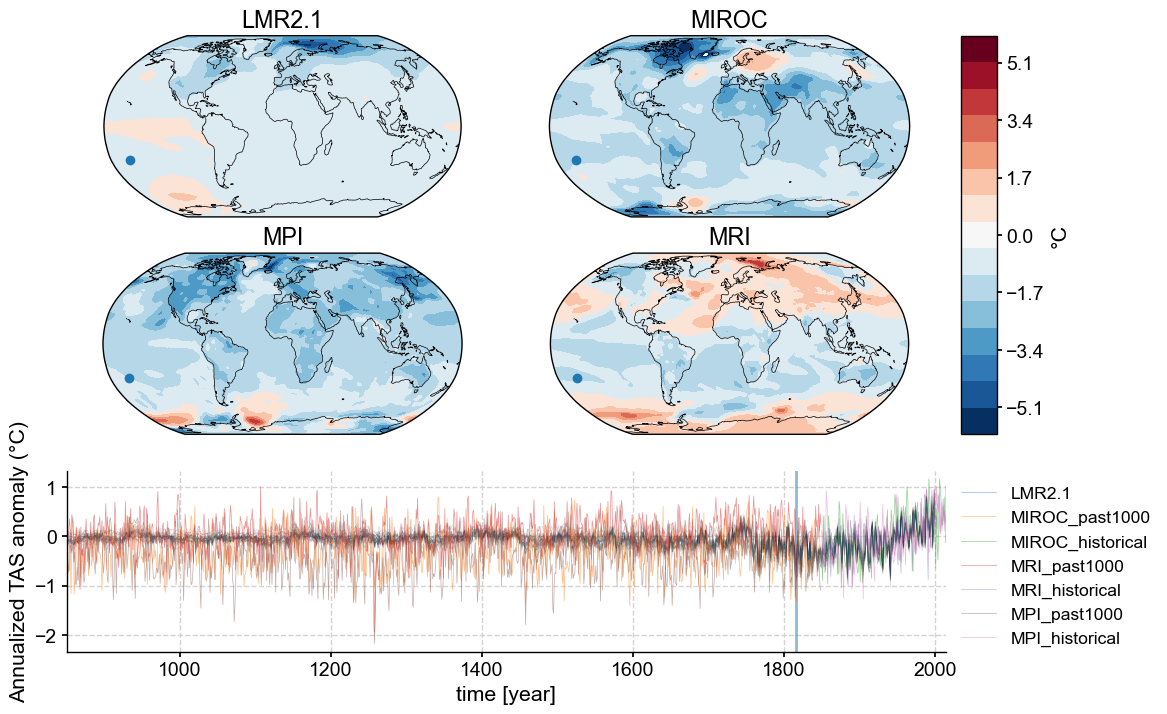

In [73]:
nc = 21
fig = plt.figure(figsize=(12, 8))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(3, 3, wspace=0.05, hspace=.2,width_ratios=[3,3,.25], height_ratios=[3,3,3])

# add subplot with specified map projection and coastlines (GeoAxes)
gs_squares = [gs[0, 0], gs[0, 1], gs[1, 0], gs[1, 1]]
axs = [fig.add_subplot(sqr, projection=ccrs.Robinson(central_longitude=0)) for sqr in gs_squares]

for ik, key in enumerate(['LMR2.1', 'MIROC', 'MPI', 'MRI']):#cmip6_snapshot_ps.keys()):
    axs[ik].add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)
    # place data on coordinate system with continuous x axis (longitude axis)
    tas_c, lonc = cutil.add_cyclic_point(cmip6_snapshot_ps[key]['snapshot'], cmip6_snapshot_ps[key]['snapshot']['lon'])
    # plot contourf on ax2 (geosubplot)
    cf2 = axs[ik].contourf(lonc,cmip6_snapshot_ps[key]['snapshot']['lat'],tas_c.squeeze(),nc, levels=ax2_levels, 
                       transform=ccrs.PlateCarree(), **cf2_kwargs)
    axs[ik].scatter(lon, lat, transform=ccrs.PlateCarree())
    axs[ik].set_title(key)

# add annotations (colorbar, title)
ax2_cb = fig.add_subplot(gs[:2, 2])
cb2 = plt.colorbar(ax2_sm,cax=ax2_cb, orientation='vertical',label="\xb0C", 
                   ticks=[loc for ik, loc in enumerate(ax2_levels) if ik%2>0])
cb2.minorticks_off()                     

# time series
ax_ts = fig.add_subplot(gs[2, :2])
ax_ts.axvline(x=time_pt, alpha=.5)
# MCruns = [ik for ik in range(2)]
for MCrun_ps in tmp_pss:
    # mcrun_ts = timeseries.sel({'MCrun':MCrun})
    MCrun_ps.plot(ax=ax_ts, color='k', alpha=.15, linewidth=.5)
    # ax1.plot(mcrun_ts.time.dt.year, mcrun_ts.data, label = str(MCrun), alpha=.5)

# CMIP6 trajectories
for key in cmip6_snapshot_ps.keys():
    for exp in cmip6_snapshot_ps[key]['ps_atloc'].keys():
        cmip6_snapshot_ps[key]['ps_atloc'][exp].plot(ax=ax_ts, linewidth=.5, alpha=.5)
        
ax_ts.legend(bbox_to_anchor=(1,1))
ax_ts.set_xlim([850, 2014])
ax_ts.set_ylabel('Annualized TAS anomaly (\xb0C)')

---

## Summary
Comparing model output to data is a critical step in assessing how well a physics-based model describes the Earth system. Here we demonstrated how to look at time series data next to spatial snapshots to tease out the details behind the larger patterns. There are many more potential things we could do with this. In future notebooks, we will:
- map the multivariate response to volcanic eruptions (see [VICS dashboards](./VICS_dashboard.md)) 
- analyze the main modes of climate variability in reconstructions and simulations.


## Resources and references

| _Citations_|
|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Hakim, G. J., Emile-Geay, J., Steig, E. J., Noone, D., Anderson, D. M., Tardif, R., Steiger, N., and Perkins, W. A. (2016), The last millennium climate reanalysis project: Framework and first results, J. Geophys. Res. Atmos., 121, 6745– 6764, doi:10.1002/2016JD024751.|
| Tardif, R., Hakim, G. J., Perkins, W. A., Horlick, K. A., Erb, M. P., Emile-Geay, J., Anderson, D. M., Steig, E. J., and Noone, D.: Last Millennium Reanalysis with an expanded proxy database and seasonal proxy modeling, Clim. Past, 15, 1251–1273,  https://doi.org/10.5194/cp-15-1251-2019 , 2019. |
|  Neukom, R., L. A. Barboza, M. P. Erb, F. Shi, J. Emile-Geay, M. N. Evans, J. Franke, D. S. Kaufman, L. Lücke, K. Rehfeld, A. Schurer, F. Zhu, S. Br ̈onnimann, G. J. Hakim, B. J. Henley, F. C. Ljungqvist, N. McKay, V. Valler, and L. von Gunten (2019), Consistent multidecadal variability in global temperature reconstructions and simulations over the common era, Nature Geoscience, 12(8), 643–649, doi:10.1038/s41561-019-0400-0. |
| Kageyama, M., Braconnot, P., Harrison, S. P., Haywood, A. M., Jungclaus, J. H., Otto-Bliesner, B. L., Peterschmitt, J.-Y., Abe-Ouchi, A., Albani, S., Bartlein, P. J., Brierley, C., Crucifix, M., Dolan, A., Fernandez-Donado, L., Fischer, H., Hopcroft, P. O., Ivanovic, R. F., Lambert, F., Lunt, D. J., Mahowald, N. M., Peltier, W. R., Phipps, S. J., Roche, D. M., Schmidt, G. A., Tarasov, L., Valdes, P. J., Zhang, Q., and Zhou, T.: The PMIP4 contribution to CMIP6 – Part 1: Overview and over-arching analysis plan, Geosci. Model Dev., 11, 1033–1057, https://doi.org/10.5194/gmd-11-1033-2018, 2018.|
